# Non-Cartesian T1 | Subspace-Constrained Reconstruction
This tutorial uses the [`BART`](http://mrirecon.github.io/bart/) command-line interface (CLI) and presents how to work with radial data using BART, with the goal of implementing a full processing pipeline from raw data to T1 maps.


## Outline
1. Bart Setup
6. Reconstruction Pulseq Data
   1. Prepare data
   2. Subspace reconstruction
   3. Postprocessing
   


**Author**: [Vitali Telezki](mailto:vitali.telezki@med.uni-goettingen.de)

**Institution**: University Medical Center Göttingen

Based on previous material written by [Daniel Mackner](mailto:daniel.mackner@tugraz.at), [Moritz Blumenthal](mailto:blumenthal@@tugraz.at) and [Jon Tamir](mailto:jtamir@utexas.edu).

In this interactive session, we recommend running BART calls in the terminal, and use this notebook as a reference. Nevertheless, we will provide some examples of how to run BART commands in this notebook to be self-contained.

**💡CAVE:💡**

- **`%%bash` Cells in Jupyter Notebooks:**
  Magic commands like `%%bash` allow you to run bash commands directly within your notebook.
  Simply prefix your cell with `%%bash`, and you can run any shell command, including calls to BART tools, just as you would in a terminal.

- **`%%pybash` Cells in this Jupyter Notebook:**
   Since it is cumbersome to redefine bash variables over and over, we use a custom magic command `%%pybash` instead. This custom magic command allows to access python variables inside the `bash` environment, making execution more convenient and consistent. The caveat here is that variables need to be enclosed by `{}` and not preceeded by `$`. Be careful, when copy-pasting code to your terminal. We use `%%bash` wherever possible for simple translation.


## Python Requirements

In [1]:
%%bash
mkdir -p ./src
wget https://owncloud.gwdg.de/index.php/s/ofa0uJGjLlGSFk4/download -O ./src/plotSubspace.py
wget https://owncloud.gwdg.de/index.php/s/uvUdR8epcdNUE36/download -O  ./src/customStyle.mplstyle

--2025-09-08 09:43:25--  https://owncloud.gwdg.de/index.php/s/ofa0uJGjLlGSFk4/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3150 (3.1K) [text/x-python]
Saving to: ‘./src/plotSubspace.py’

     0K ...                                                   100% 1.19G=0s

2025-09-08 09:43:25 (1.19 GB/s) - ‘./src/plotSubspace.py’ saved [3150/3150]

--2025-09-08 09:43:25--  https://owncloud.gwdg.de/index.php/s/uvUdR8epcdNUE36/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349 [application/octet-stream]
Saving to: ‘./src/customStyle.mplstyle’

     0K                                                       100%  390M=0s

2025-09-08 09:43:25 (390 MB/s) - ‘./src/customStyle.mplstyle’

In [2]:
from IPython import get_ipython
from IPython.core.magic import register_cell_magic

ipython = get_ipython()


@register_cell_magic
def pybash(line, cell):
    ipython.run_cell_magic('bash', '', cell.format(**globals()))

## Bart Setup
### Google Colab
The cell will setup BART on Google Colab. For a detailed explanation, see **How to Run BART on Google Colaboratory** [here](https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/bart_on_colab/colab_gpu_tutorial.ipynb). You can skip this part if you want to run this notebook on your local machine.

This tutorial do need a GPU, you can select one by going to **Edit → Notebook settings**: Choose **GPU** from **Hardware accelerator** drop-down menu.

In [3]:
%%bash

# Why Google?! As of May 13 cuda installed in colab (12.5) is incompatible with the driver (12.4)
# We install cuda 12.4 and link it here but it takes time!
apt install cuda-12-4

cd /usr/local
rm cuda
ln -s cuda-12.4 cuda

[ -d bart-webinars ] && rm -r bart-webinars
git clone https://github.com/mrirecon/bart-webinars.git > /dev/null

echo "GPU Information:"
nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
nvcc --version


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cccl-12-4 cuda-command-line-tools-12-4 cuda-compiler-12-4 cuda-crt-12-4
  cuda-cudart-12-4 cuda-cudart-dev-12-4 cuda-cuobjdump-12-4 cuda-cupti-12-4
  cuda-cupti-dev-12-4 cuda-cuxxfilt-12-4 cuda-demo-suite-12-4
  cuda-documentation-12-4 cuda-driver-dev-12-4 cuda-drivers cuda-drivers-580
  cuda-gdb-12-4 cuda-libraries-12-4 cuda-libraries-dev-12-4 cuda-nsight-12-4
  cuda-nsight-compute-12-4 cuda-nsight-systems-12-4 cuda-nvcc-12-4
  cuda-nvdisasm-12-4 cuda-nvml-dev-12-4 cuda-nvprof-12-4 cuda-nvprune-12-4
  cuda-nvrtc-12-4 cuda-nvrtc-dev-12-4 cuda-nvtx-12-4 cuda-nvvm-12-4
  cuda-nvvp-12-4 cuda-opencl-12-4 cuda-opencl-dev-12-4 cuda-profiler-api-12-4
  cuda-runtime-12-4 cuda-sanitizer-12-4 cuda-toolkit-12-4
  cuda-toolkit-12-4-config-common cuda-tools-12-4 cuda-visual-tools-12-4
  default-jre default-jre-headless dkms fakeroot fonts-dejavu-core
  fonts-



Cloning into 'bart-webinars'...
Updating files: 100% (156/156), done.


In [4]:
%%bash
apt-get install -y make  gcc-12 g++-12 libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null


In [5]:
%%bash
[ -d /content/bart ] && rm -r /content/bart

git clone https://github.com/mrirecon/bart/ bart &> /dev/null

Install BART

In [7]:
%%bash
cd bart
COMPILE_SPECS=" PARALLEL=1
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64
                OPENBLAS=1
                BLAS_THREADSAFE=1
                CC=gcc-12"


printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local
make &> /dev/null


Set environment variables: enables correct path to BART

In [8]:
# Define environment variables for BART and OpenMP
import os
import sys
os.environ['TOOLBOX_PATH'] = "/content/bart"
os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

Test, if BART is installed correctly

In [9]:
%%bash
echo "# BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# BART used in this notebook:
/content/bart/bart
# BART version: 
v0.9.00-1156-gd911ee9


### Download phantom data. **Replace URL to get data we just recorded.**

In [10]:
!wget https://cloud.tugraz.at/index.php/s/TJ8TcxR456t88MP/download/ksp_irraga.ra -O meas.ra

--2025-09-08 09:59:49--  https://cloud.tugraz.at/index.php/s/TJ8TcxR456t88MP/download/ksp_irraga.ra
Resolving cloud.tugraz.at (cloud.tugraz.at)... 129.27.2.164
Connecting to cloud.tugraz.at (cloud.tugraz.at)|129.27.2.164|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://cloud.tugraz.at/public.php/dav/files/TJ8TcxR456t88MP/?accept=zip [following]
--2025-09-08 09:59:50--  https://cloud.tugraz.at/public.php/dav/files/TJ8TcxR456t88MP/?accept=zip
Reusing existing connection to cloud.tugraz.at:443.
HTTP request sent, awaiting response... 200 OK
Length: 83386544 (80M) [application/octet-stream]
Saving to: ‘meas.ra’

meas.ra             100%[===================>]  79.52M  4.59MB/s    in 18s     

2025-09-08 10:00:08 (4.50 MB/s) - ‘meas.ra’ saved [83386544/83386544]



In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# import os
# import sys
import src.plotSubspace as ps
# import numpy as np
# import importlib

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['ggplot', 'src/customStyle.mplstyle'])

## Reconstruction Pulseq Data

Now, we aim to reconstruct data obtained with Pulseq and a sequence prepared by `bart seq`.
First, we create a signal dictionary, then we perform a SVD and finally create the temporal basis used in subspace reconstruction.


### Convert dat file to cfl
First, we need to convert Siemens `.dat` file to bart `.cfl/.hdr` file format using `bart twixread` and check input file dimensions.

In [12]:
%%bash
# bart twixread -A -r 1 meas.dat tmp_ksp

bart copy meas.ra tmp_ksp
head -n2 tmp_ksp.hdr

# Dimensions
1 512 1131 18 1 1 1 1 1 1 1 1 1 1 1 1 


We notice `PHS2_DIM` should be `TE_DM` instead.

In [13]:
%%bash
bart transpose 2 5 tmp_ksp tmp_ksp
head -n2 tmp_ksp.hdr

# Dimensions
1 512 1 18 1 1131 1 1 1 1 1 1 1 1 1 1 


### Trajectory and Sequence Params
You should have all relevant information from initial use of `bart seq`, when preparing Pulseq sequence. In case that is lost, we rerun the following commands.

In [14]:
FIBO=377  # fibonacci number satisfying Nyquist when using RAGA
FRAMES=3
REP=int(FIBO*FRAMES)

In [15]:
%%pybash

bart seq --IR_NON --raga -t {REP} -r {FIBO} grad mom adc
bart vec 1 1 0 tmp_a
bart extract 0 2 5 adc - | bart fmac - tmp_a traj
bart scale 0.5 traj traj
head -n2 traj.hdr

# Dimensions
3 512 377 1 1 1 1 1 1 1 3 1 1 1 1 1 


loops: 3837483 	 dims: [  1 377   1   1   1   1   3   3 377   1   3   1   1   1   1   1 ]
kernels: 1131 	 dims: [  1 377   1   1   1   1   1   1   1   1   3   1   1   1   1   1 ]
Nr. of RF shapes: 2


For subspace reco, all spokes in dim 5:

In [16]:
%%pybash
bart reshape $(bart bitmask 2 10) 1 {REP} traj - | bart transpose 5 10 - traj
head -n2 traj.hdr

# Dimensions
3 512 1 1 1 1131 1 1 1 1 1 1 1 1 1 1 


## Create Dictionary

The signal model according to Look-Locker in voxel $r$ at time $t$ is
$$
M(t,r)~=~M_{ss}(r)~-~\left[M_{ss}(r)~+~M_{0}(r)\right]~e^{-tR_1^*(r)}.~
$$

Using `bart signal` we create our signal dictionary with `nR1s` values for R1star and `nMss` values for steady-state magnetization.

In [17]:
TR=0.00311 # [s] , BlockDurationRaster x DUR = 1e-05 x 311 = 0.00311
nR1s=1000
nMss=100

In [18]:
%%pybash
### create vector with inversion times nREP*TR
bart index 5 {REP} - | bart scale {TR} - TI
bart signal -F -I -n {REP} -r {TR} -1 5e-3:5:{nR1s} -3 1e-2:1:{nMss} tmp_dict
# reshape the dictionary to have all the elements on the 6th dimension
bart reshape $(bart bitmask 6 7) $(({nR1s} * {nMss})) 1 tmp_dict tmp_dict1
head -n2 tmp_dict1.hdr
# squeeze the dicc1 before SVD
bart squeeze tmp_dict1 subspace_dict
head -n2 subspace_dict.hdr
# perform SVD on dictionary
bart svd -e subspace_dict U S V

# Dimensions
1 1 1 1 1 1131 100000 1 1 1 1 1 1 1 1 1 
# Dimensions
1131 100000 


### Visualize simulated dictionay and PCA coeffcients

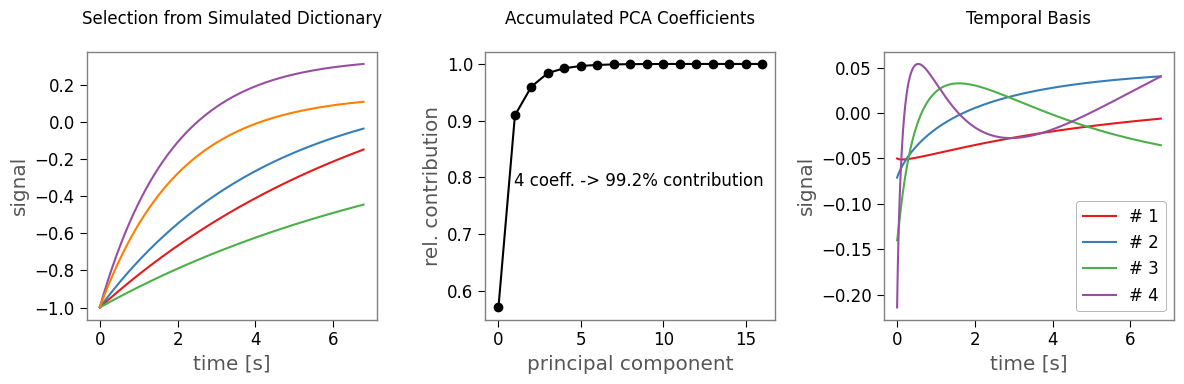

In [19]:
ps.plotSubspace()

### Estimate Coil Sensitivities Using Subspace
We realized, that 4 PCA coefficients contribute to more than 99% of the observed signal. Hence, we can reduce our basis to only contain the first 4 eigenvectors. We create a subspace basis spanned by those 4 eigenvectors.

In [20]:
nCoe = 4 ## use 4 coefficients

In [21]:
%%pybash

# create the temporal basis
bart extract 1 0 {nCoe} U subbasis
# transpose the basis to have time on the 6th dimension and coefficients on the 5th dimension
bart transpose 1 6 subbasis - | bart transpose 0 5 - subbasis

For consistency, check dimensions of subbasis, input data and trajectory:

In [22]:
%%bash

head -n2 subbasis.hdr
head -n2 tmp_ksp.hdr
head -n2 traj.hdr


# Dimensions
1 1 1 1 1 1131 4 1 1 1 1 1 1 1 1 1 
# Dimensions
1 512 1 18 1 1131 1 1 1 1 1 1 1 1 1 1 
# Dimensions
3 512 1 1 1 1131 1 1 1 1 1 1 1 1 1 1 



 Now, we estimate coil sensitivities using `bart ncalib` and reduced subspace basis in one go.

In [23]:
%%bash

DEBUG_LEVEL=4 bart ncalib -g -N -i16 -t traj -B subbasis tmp_ksp sens_ncalib

Est. image size: 256 256 1
ksp : [  1 512   1  18   1 1131   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 48  48   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 1131   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: low-mem mode
NUFFT: Toeplitz mode

Model created (non Cartesian, nufft-based):
kspace:     [  1 512   1  18   1 1131   1   1   1   1   1   1   1   1   1   1 ]
images:     [ 48  48   1   1   1   1   4   1   1   1   1   1   1   1   1   1 ]
coils:      [ 16  16   1  18   1   1   1   1   1   1   1   1   1   1   1   1 ]
trajectory: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
pattern:    [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
basis:      [  1   1   1   1   1 1131   4   1   1   1   1   1   1   1   1   1 ]
mask:       [  1   1   1   1   1   1   1

### Perform reconstruction

Using estimated coil sensitvities, we can now perform parrallel imaging reconstruction with `bart pics`. We use the following parameter for iterations and regularization.

In [24]:
ITER=100
REG=0.0005


In [26]:
%%pybash
# # reconstruction with subspace constraint
bart pics -g -e -d5 -i {ITER} -R W:$(bart bitmask 0 1):$(bart bitmask 6):{REG} -B subbasis -t traj tmp_ksp sens_ncalib subspace_reco

Basis: [256 256   1  18   1 1131   4   1   1   1   1   1   1   1   1   1 ]
Max:   [256 256   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
GPU reconstruction
[  1 512   1  18   1 1131   4   1   1   1   1   1   1   1   1   1 ]
[256 256   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512   1  18   1 1131   4   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1  18   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 1131   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
psf_dims: [256 256   1   1   1 1131   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   1   1   1  16   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1131   1   1   1   1   1   1   1   1   1   1   

We can visualize the first 4 coefficients projected onto our data set

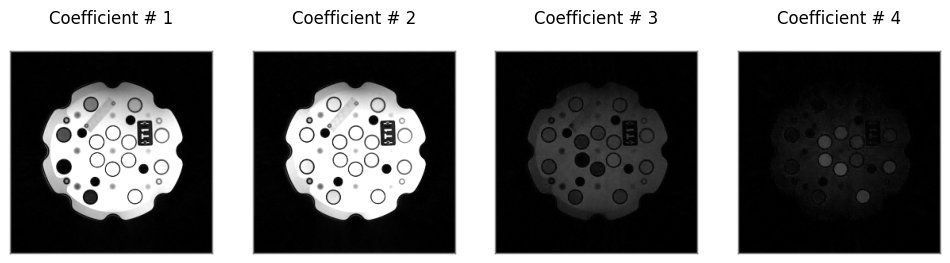

In [27]:
ps.plotCoefficientMaps()


In [28]:
%%bash
## by chance, 2nd coefficient map also suitable for mask
bart slice 6 1 subspace_reco - | bart threshold -B 0.3 - mask
bart fmac mask subspace_reco subspace_reco

### Temporal Signal Evolution

We can also project our subbasis onto all spokes, resulting in temporal signal evolution.

In [29]:
%%bash
bart fmac -s $(bart bitmask 6) subbasis subspace_reco imgs

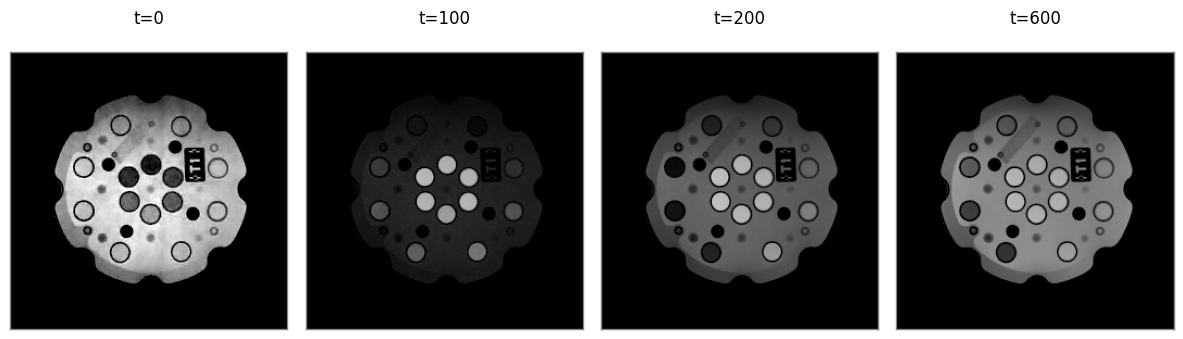

In [31]:
ps.plotTemporalEvolution()


### T1 Map from Reconstructed Images
Using `bart mobafit` we obtain T1 parameter map via pixel-wise fitting.

In [32]:
%%pybash
### create vector with inversion times nREP*TR
bart index 5 {REP} - | bart scale {TR} - TI

DEBUG_LEVEL=4 bart mobafit -g -i20 --init 1:1:1 -B subbasis -L TI subspace_reco - | bart looklocker -t0 -D15.3e-3 - t1map

Temp file for pipe: bart-5IlUgI
Step: 0, Res: 5747.415077
	 cg:  11
Step: 1, Res: 143.756656
	 cg:  10
Step: 2, Res: 20975142421.382660
	 cg:  50
Step: 3, Res: nan
	 cg:  50
Step: 4, Res: nan
	 cg:  50
Step: 5, Res: nan
	 cg:  50
Step: 6, Res: nan
	 cg:  50
Step: 7, Res: nan
	 cg:  50
Step: 8, Res: nan
	 cg:  50
Step: 9, Res: nan
	 cg:  50
Step: 10, Res: nan
	 cg:  50
Step: 11, Res: nan
	 cg:  50
Step: 12, Res: nan
	 cg:  50
Step: 13, Res: nan
	 cg:  50
Step: 14, Res: nan
	 cg:  50
Step: 15, Res: nan
	 cg:  50
Step: 16, Res: nan
	 cg:  50
Step: 17, Res: nan
	 cg:  50
Step: 18, Res: nan
	 cg:  50
Step: 19, Res: nan
	 cg:  50
Total Time: 4.59 s
Freed 3611607760 bytes.


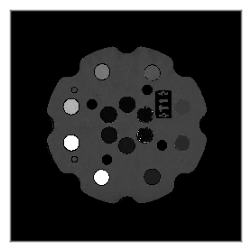

In [33]:

ps.plotT1Map()